This is practice code I did while taking **NLP For Deep Learning** Course in DataQuest

Topic covered:
1. Text Processing + EDA
2. Import, load, split, sampling data
3. Text Vectorization
4. Embedding Layer
5. Model: Simple RNN, Deep NN
6. Model: Global Pooling 1D
7. Model: Simple LSTM, Single Bidirectional, Multi Bidirectional, add argument merge_mode to Bidirectional
8. Hyperparameter Tuning Strategy: Start simple model add complexity later (number of layer, neuron, model type), Dropout layer, Regularization, Changing (LR, activation function, optimizer), Add more data

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

In [ ]:
# MODULE FOR TEXT PROCESSING
import re
# Tokenization >> breaking up a sentence into individual words or tokens
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Stopwords >> filter out commonly-used words from text that do not contain contextual meaning
nltk.download('stopwords')
from nltk.corpus import stopwords

# Lemmatization >> reducing them to their base form
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Data Preparation

In [ ]:
# load dataset from tfds
imdb_data = tfds.load(name="imdb_reviews", split="train")
imdb_df = tfds.as_dataframe(imdb_data)
imdb_df.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


In [ ]:
print("imdb shape:", imdb_df.shape)

imdb shape: (25000, 2)


In [ ]:
# we still can see byte string b" prefixed to that text,
# let's decode the byte string using the pandas vectorized string method str.decode()
imdb_df['text'] = imdb_df['text'].str.decode('utf-8')
imdb_df.tail()

,label,text
24995,0,"I have a severe problem with this show, severa..."
24996,1,"The year is 1964. Ernesto ""Che"" Guevara, havin..."
24997,0,Okay. So I just got back. Before I start my re...
24998,0,When I saw this trailer on TV I was surprised....
24999,1,"First of all, Riget is wonderful. Good comedy ..."


In [ ]:
# chcek the distribution of the target variable
imdb_df['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [ ]:
# example of negative review
imdb_df['text'][0]

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [ ]:
# checking missing value
imdb_df.isnull().sum()

label    0
text     0
dtype: int64

# EDA

In [ ]:
# this is how we sampling dataset
imdb_sample = imdb_df.sample(frac=0.2, random_state=42)
imdb_sample.shape

(5000, 2)

In [ ]:
# see the label distribution in imdb_sample
imdb_sample['label'].value_counts()

0    2576
1    2424
Name: label, dtype: int64

In [ ]:
# how long the text is?
imdb_sample['text_length'] = [len(review.split(' ')) for review in imdb_sample['text']]
imdb_sample.tail()

,label,text,text_length
8670,0,"I have seen a lot of movies in my life, but no...",135
11839,0,This is not a film you can really analyse sepa...,773
4013,1,Imagine that I was about to miss this great cu...,224
21147,1,Gundam Wing is an amazing show from start to f...,416
695,0,Probable reasons why so many people on this si...,180


In [ ]:
# prettier my exploration
imdb_sample_stats = imdb_sample.groupby('label')[['text_length']].agg({
    'mean', 'median', 'std'
})
imdb_sample_stats

text_length                   
              std        mean median
label                               
0      165.829162  230.234084  175.0
1      186.027852  236.627475  174.5

* the std in positive reviews is higher than the std in negative reviews
* both positive and negative label have text length around 230 words
* both positive and negative label have median text length around 174 words

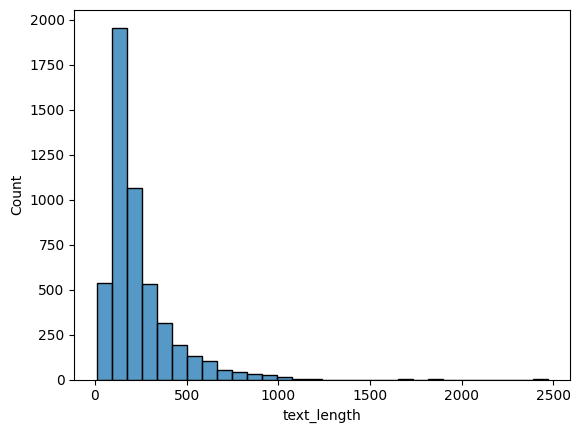

In [ ]:
sns.histplot(imdb_sample['text_length'], bins=30)
plt.show()
# as we've seen in above table, mostly the word length is distributed in 200

### Visualizing the most frequently used word (stopwords included)

In [ ]:
# calculate frequency of the word in the imdb sample
freq_words = imdb_sample['text'].str.split(expand=True).stack().value_counts()

In [ ]:
# visualize top 100 words in treemap
freq_words_top100 = freq_words[:100]

fig = px.treemap(freq_words_top100, path=[freq_words_top10.index], values=0)
fig.update_layout(title_text='Most Frequent 100 Words in the imdb sample dataset', title_font=dict(size=20), uniformtext=dict(minsize=25, mode='show'))
fig.show()

* 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'I', 'that', 'this' become top 10 word that apper frequently
* they're stopwords. they couldn't give us any further explanation

# Text Preprocessing

1. Coverting the text to lowercase
2. Removing punctuation from the text
3. Tokenizing the text
4. Removing stopwords from the text
5. Lemmatization (Stemming) of the text

In [ ]:
# convert to lowercase
imdb_df['text'] = imdb_df['text'].str.lower()

In [ ]:
# remove punctuation
def punctuation(inputs):
    return re.sub(r'[^\w\s]', ' ', inputs)
    # this code substitute any non-word (^\w) and non-space (^\s) characters with a space ' ' in the 'text' column of the imdb df dataframe

imdb_df['text'] = imdb_df['text'].apply(punctuation)

In [ ]:
# tokenizing the text
def tokenization(inputs):
    return word_tokenize(inputs)

imdb_df['text'] = imdb_df['text'].apply(tokenization)

In [ ]:
# stopwords removal
stop_words = set(stopwords.words('english'))
stop_words.remove('not') # the word 'not' is important for correctly identifying positive and negative reviews, hence remove it from stop_words list
stop_words.add('br') # add the word 'br' to the set of stopwords because it's an HTML tag and should be ignored during our analysis

def stopwords_remove(inputs):
    return [word for word in inputs if word not in stop_words]

imdb_df['text'] = imdb_df['text'].apply(stopwords_remove)

In [ ]:
# stemming
lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=word, pos='v') for word in inputs] #pos is part of speech, in this case we use verb

imdb_df['text'] = imdb_df['text'].apply(lemmatization)

In [ ]:
imdb_df.head()

,label,text
0,0,"[absolutely, terrible, movie, lure, christophe..."
1,0,"[know, fall, asleep, film, usually, due, combi..."
2,0,"[mann, photograph, alberta, rocky, mountains, ..."
3,1,"[kind, film, snowy, sunday, afternoon, rest, w..."
4,1,"[others, mention, women, go, nude, film, mostl..."


In [ ]:
# join the token for each reviews, rather than in the form of a single block of text.
df_final = imdb_df.copy()
df_final['processed'] = df_final['text'].str.join(' ')
df_final

,label,text,processed
0,0,"[absolutely, terrible, movie, lure, christophe...",absolutely terrible movie lure christopher wal...
1,0,"[know, fall, asleep, film, usually, due, combi...",know fall asleep film usually due combination ...
2,0,"[mann, photograph, alberta, rocky, mountains, ...",mann photograph alberta rocky mountains superb...
3,1,"[kind, film, snowy, sunday, afternoon, rest, w...",kind film snowy sunday afternoon rest world go...
4,1,"[others, mention, women, go, nude, film, mostl...",others mention women go nude film mostly absol...
...,...,...,...
24995,0,"[severe, problem, show, several, actually, sim...",severe problem show several actually simple li...
24996,1,"[year, 1964, ernesto, che, guevara, cuban, cit...",year 1964 ernesto che guevara cuban citizen la...
24997,0,"[okay, get, back, start, review, let, tell, on...",okay get back start review let tell one thing ...
24998,0,"[saw, trailer, tv, surprise, may, 2008, six, f...",saw trailer tv surprise may 2008 six flag new ...


## Most Frequent words after processing

In [ ]:
# let's see the top 100 word after we preprocessed it
# calculate frequency of the word in processed column
freq_words_prc = df_final['processed'].str.split(expand=True).stack().value_counts()

In [ ]:
# visualize top 100 words in treemap
freq_words_prc_top100 = freq_words_prc[:100]

fig = px.treemap(freq_words_prc_top100, path=[freq_words_prc_top100.index], values=0)
fig.update_layout(title_text='Most Frequent 100 Words in the processed imdb dataset', title_font=dict(size=20), uniformtext=dict(minsize=25, mode='show'))
fig.show()

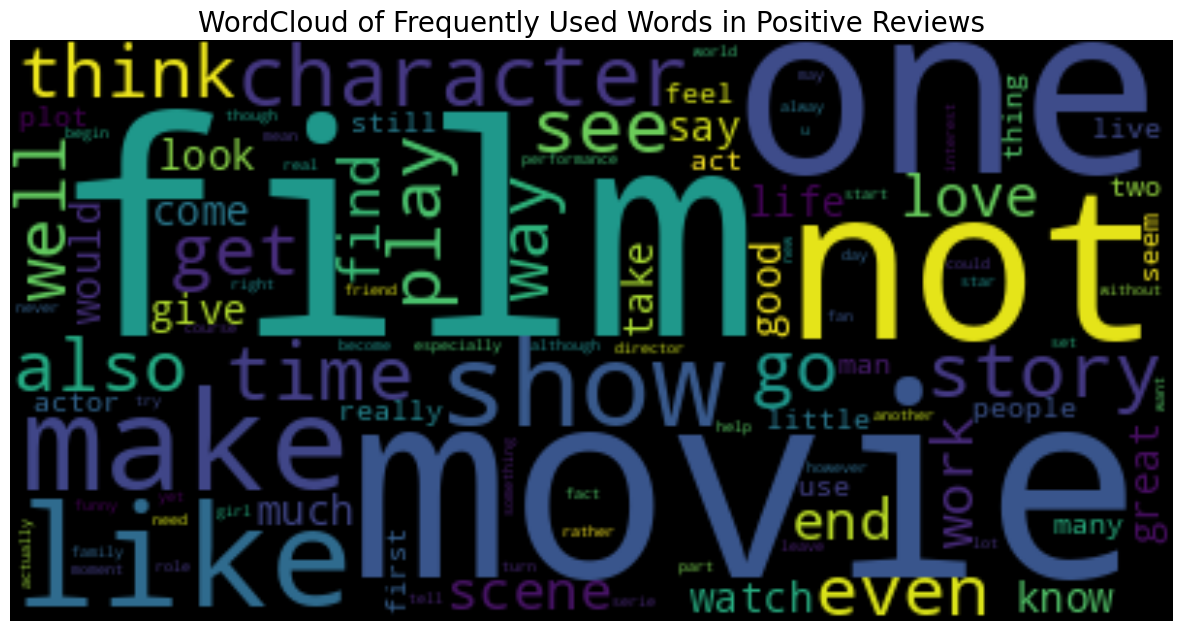

In [ ]:
# split dataset for positive reviews
df_final_pos = df_final[df_final['label'] == 1]

# word cloud visualization for positive reciews
all_pos_text = ' '.join(df_final_pos['processed'].tolist())
word_cloud_1 = WordCloud(max_words=100, stopwords=stop_words, random_state=100).generate(all_pos_text)

plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Positive Reviews', fontsize=20)
plt.axis("off")
plt.show()

In [ ]:
word_cloud_1.words_

{'film': 1.0,
 'movie': 0.7942841235965482,
 'one': 0.7652407905725156,
 'not': 0.5720515913519533,
 'like': 0.4855711236893384,
 'make': 0.44492901549596364,
 'show': 0.4436299526769973,
 'character': 0.4324951285144289,
 'time': 0.3858216572329962,
 'see': 0.3833163217964183,
 'story': 0.3794191333395193,
 'think': 0.3637375893105688,
 'get': 0.36253131669295724,
 'also': 0.3591908694441867,
 'play': 0.3588197086387677,
 'go': 0.3504685905168414,
 'even': 0.3471281432680709,
 'well': 0.32263153011042034,
 'way': 0.3194766632643593,
 'love': 0.317806439639974,
 'end': 0.2989700287649624,
 'find': 0.2969286443351582,
 'scene': 0.2837524357427856,
 'work': 0.2766075902384708,
 'give': 0.26380254245151713,
 'watch': 0.25684327734991186,
 'know': 0.250440753456435,
 'life': 0.24979122204695184,
 'look': 0.24580124338869816,
 'much': 0.24236800593857288,
 'come': 0.24218242553586342,
 'good': 0.2351303702329034,
 'great': 0.22789273452723394,
 'take': 0.22770715412452444,
 'say': 0.2253873

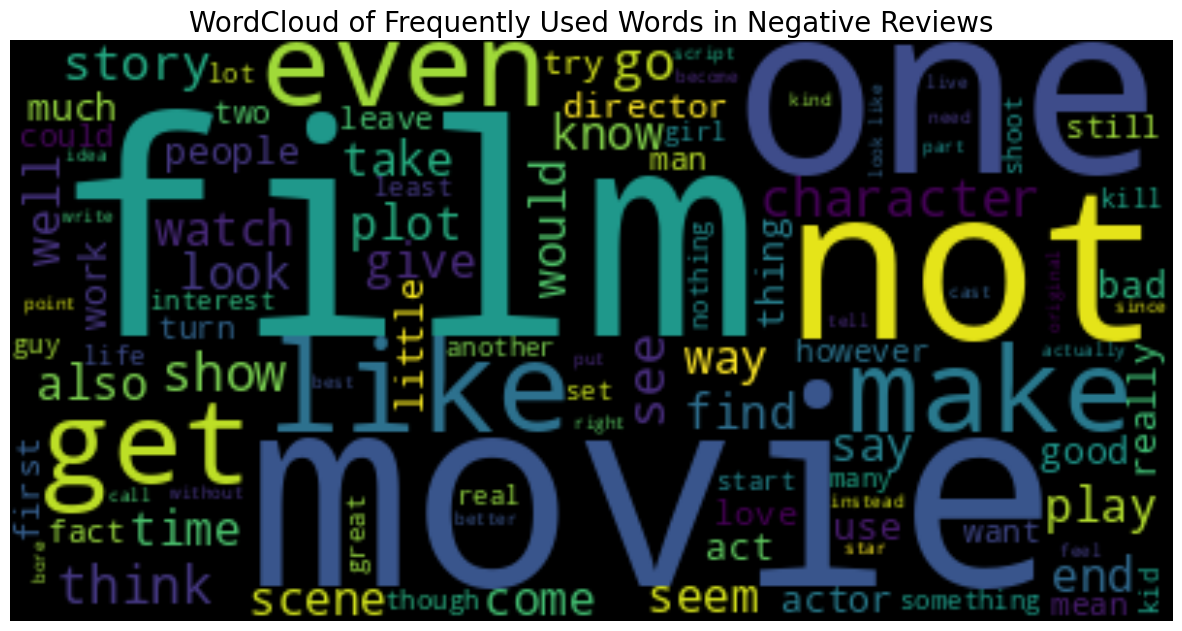

In [ ]:
# split dataset for negative reviews
df_final_neg = df_final[df_final['label'] == 0]

# word cloud visualization for positive reciews
all_neg_text = ' '.join(df_final_neg['processed'].tolist())
word_cloud_0 = WordCloud(max_words=100, stopwords=stop_words, random_state=100).generate(all_neg_text)

plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_0, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Negative Reviews', fontsize=20)
plt.axis("off")
plt.show()

In [ ]:
word_cloud_0.words_

{'film': 1.0,
 'movie': 0.8379664179104478,
 'one': 0.7597014925373134,
 'not': 0.5799440298507462,
 'like': 0.5271455223880597,
 'make': 0.44477611940298506,
 'get': 0.44160447761194027,
 'even': 0.4357276119402985,
 'character': 0.4115671641791045,
 'think': 0.3982276119402985,
 'go': 0.38386194029850745,
 'show': 0.37901119402985073,
 'see': 0.37807835820895525,
 'story': 0.3316231343283582,
 'scene': 0.30951492537313435,
 'end': 0.30550373134328357,
 'way': 0.3045708955223881,
 'know': 0.302705223880597,
 'say': 0.29906716417910445,
 'time': 0.2896455223880597,
 'also': 0.2871268656716418,
 'well': 0.2855410447761194,
 'look': 0.2794776119402985,
 'come': 0.2704291044776119,
 'play': 0.26147388059701493,
 'plot': 0.25457089552238804,
 'find': 0.25410447761194027,
 'watch': 0.2513992537313433,
 'give': 0.24813432835820895,
 'would': 0.24608208955223881,
 'take': 0.24458955223880596,
 'seem': 0.23955223880597015,
 'people': 0.23442164179104477,
 'act': 0.23348880597014926,
 'work': 0

# GO FURTHER WITH RNNs

In [30]:
from tensorflow.keras.layers import TextVectorization, Embedding

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, layers

from tensorflow.keras.regularizers import L1, L2, L1L2

In [3]:
# assuming you're run code from here (split='train')
imdb_data_train = tfds.load(name="imdb_reviews", split="train")
imdb_train = tfds.as_dataframe(imdb_data_train)
imdb_train['text'] = imdb_train['text'].str.decode('utf-8')

# sample train
imdb_sample_train = imdb_train.sample(frac=0.2, random_state=100)
print('imdb train shape: ', imdb_train.shape)
print('imdb sample train shape: ', imdb_sample_train.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWG8ILT/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWG8ILT/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWG8ILT/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
imdb train shape:  (25000, 2)
imdb sample train shape:  (5000, 2)


In [6]:
# (split='test')
imdb_data_test = tfds.load(name="imdb_reviews", split="test")
imdb_test = tfds.as_dataframe(imdb_data_test)
imdb_test['text'] = imdb_test['text'].str.decode('utf-8')

# sample test
imdb_sample_test = imdb_test.sample(frac=0.2, random_state=100)
print('imdb test shape: ', imdb_test.shape)
print('imdb sample test shape: ', imdb_sample_test.shape)

imdb test shape:  (25000, 2)
imdb sample test shape:  (5000, 2)


### Were asked to use data sample

In [5]:
# split train sample into train_sample and test_sample set
X_train_sample = imdb_sample_train['text']
y_train_sample = imdb_sample_train['label']
print(X_train_sample.shape, y_train_sample.shape)

(5000,) (5000,)


In [7]:
# split test sample into train_sample and test_sample set
X_test_sample = imdb_sample_test['text']
y_test_sample = imdb_sample_test['label']
print(X_test_sample.shape, y_test_sample.shape)

(5000,) (5000,)


### Were asked to use all data, instead of sampling them

In [8]:
# split the whole train to X and y
X_train_full = imdb_train['text']
y_train_full = imdb_train['label']
print(X_train_full.shape, y_train_full.shape)

(25000,) (25000,)


In [9]:
# split the whole test into X and y
X_test_full = imdb_test['text']
y_test_full = imdb_test['label']
print(X_test_full.shape, y_test_full.shape)

(25000,) (25000,)


In [17]:
# Global variables
max_tokens = 20000
output_sequence_length = 128
output_dim = 128

## Text Vectorization

The process of converting text into numerical vectors, which can then serve as input for deep learning algorithms.

In [10]:
# these value was taken considering our dataset
vectz_layer = TextVectorization(max_tokens=max_tokens, standardize='lower_and_strip_punctuation', output_mode='int',
                                output_sequence_length=output_sequence_length,
                                ngrams=(1,2))

In [11]:
# fit text vectorization to our sample training data
vectz_layer.adapt(X_train_sample)

# fit text vectorization to our training data
vectz_layer.adapt(X_train_full)

## Training model using sample data

### Baseline model

In [13]:
# construct model
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectz_layer)
model.add(layers.Dense(16))
model.add(layers.Dense(1, activation='sigmoid'))

# model compiling
opt = tf.optimizers.Adam(learning_rate=0.01)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# model training
model.fit(
    X_train_sample,
    y_train_sample,
    epochs=10
)

Epoch 1/10
157/157 [==============================] - 6s 9ms/step - loss: 767.7087 - accuracy: 0.4992
Epoch 2/10
157/157 [==============================] - 2s 10ms/step - loss: 36.7496 - accuracy: 0.5058
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 31.3661 - accuracy: 0.5190
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 29.3300 - accuracy: 0.5026
Epoch 5/10
157/157 [==============================] - 1s 7ms/step - loss: 24.6160 - accuracy: 0.5198
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 24.2598 - accuracy: 0.5072
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 18.9745 - accuracy: 0.5058
Epoch 8/10
157/157 [==============================] - 1s 7ms/step - loss: 17.5629 - accuracy: 0.5174
Epoch 9/10
157/157 [==============================] - 1s 7ms/step - loss: 13.5046 - accuracy: 0.5044
Epoch 10/10
157/157 [==============================] - 1s 7ms/step - loss: 15.7731 - accu

In [14]:
# model evaluation
test_loss, test_acc = model.evaluate(X_test_sample, y_test_sample)
print(f"Test set accuracy: {test_acc}")

157/157 [==============================] - 1s 6ms/step - loss: 17.1731 - accuracy: 0.4966
Test set accuracy: 0.4966000020503998


### Add Embedding Layer

It takes a sequence of integer-encoded words as input and returns a matrix where each row contains the numerical representation (embedding) of the corresponding word.

In [ ]:
embedd_layer = tf.keras.layers.Embedding(input_dim=max_tokens,
                                         output_dim=128,
                                         input_length=output_sequence_length)

In [15]:
model_2 = Sequential()
model_2.add(Input(shape=(1,), dtype=tf.string))
model_2.add(vectz_layer)
model_2.add(embedd_layer)
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

# model compiling
opt = tf.optimizers.Adam(learning_rate=0.01)

model_2.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# model trining
model_2.fit(
    X_train_sample,
    y_train_sample,
    epochs=10
)

Epoch 1/10
157/157 [==============================] - 27s 166ms/step - loss: 0.6875 - accuracy: 0.5320
Epoch 2/10
157/157 [==============================] - 16s 100ms/step - loss: 0.6797 - accuracy: 0.5460
Epoch 3/10
157/157 [==============================] - 8s 52ms/step - loss: 0.6772 - accuracy: 0.5490
Epoch 4/10
157/157 [==============================] - 7s 45ms/step - loss: 0.6751 - accuracy: 0.5486
Epoch 5/10
157/157 [==============================] - 6s 41ms/step - loss: 0.6743 - accuracy: 0.5536
Epoch 6/10
157/157 [==============================] - 4s 29ms/step - loss: 0.6746 - accuracy: 0.5505
Epoch 7/10
157/157 [==============================] - 5s 33ms/step - loss: 0.6738 - accuracy: 0.5554
Epoch 8/10
157/157 [==============================] - 3s 19ms/step - loss: 0.6735 - accuracy: 0.5535
Epoch 9/10
157/157 [==============================] - 2s 14ms/step - loss: 0.6736 - accuracy: 0.5523
Epoch 10/10
157/157 [==============================] - 3s 22ms/step - loss: 0.6733 - ac

In [16]:
# model evaluation
test_loss, test_acc = model_2.evaluate(X_test_sample, y_test_sample)
print(f"Test set accuracy: {test_acc}")

157/157 [==============================] - 1s 7ms/step - loss: 0.6904 - accuracy: 0.5372
Test set accuracy: 0.5372281074523926


### Deep NN

In [19]:
model_simple_dense = Sequential()
model_simple_dense.add(Input(shape=(1,), dtype=tf.string))
model_simple_dense.add(vectz_layer)
model_simple_dense.add(embedd_layer)
model_simple_dense.add(layers.Dense(64, activation='relu'))
model_simple_dense.add(layers.Dense(64, activation='relu'))
model_simple_dense.add(layers.Dense(64, activation='relu'))
model_simple_dense.add(layers.Dense(64, activation='relu'))
model_simple_dense.add(layers.Dense(64, activation='relu'))
model_simple_dense.add(layers.Dense(1, activation='sigmoid'))

# model compiling
opt = tf.optimizers.Adam(learning_rate=0.01)

model_simple_dense.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# model training
model_simple_dense.fit(
    X_train_sample,
    y_train_sample,
    epochs=10
)

Epoch 1/10
157/157 [==============================] - 26s 151ms/step - loss: 0.6772 - accuracy: 0.5448
Epoch 2/10
157/157 [==============================] - 13s 82ms/step - loss: 0.6738 - accuracy: 0.5569
Epoch 3/10
157/157 [==============================] - 10s 65ms/step - loss: 0.6743 - accuracy: 0.5558
Epoch 4/10
157/157 [==============================] - 8s 52ms/step - loss: 0.6735 - accuracy: 0.5579
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.6730 - accuracy: 0.5636
Epoch 6/10
157/157 [==============================] - 4s 28ms/step - loss: 0.6727 - accuracy: 0.5611
Epoch 7/10
157/157 [==============================] - 5s 31ms/step - loss: 0.6724 - accuracy: 0.5576
Epoch 8/10
157/157 [==============================] - 3s 22ms/step - loss: 0.6721 - accuracy: 0.5583
Epoch 9/10
157/157 [==============================] - 4s 23ms/step - loss: 0.6729 - accuracy: 0.5580
Epoch 10/10
157/157 [==============================] - 3s 22ms/step - loss: 0.6729 - ac

In [20]:
# model evaluation
test_loss, test_acc = model_simple_dense.evaluate(X_test_sample, y_test_sample)
print(f"Test set accuracy: {test_acc}")

157/157 [==============================] - 2s 9ms/step - loss: 0.7017 - accuracy: 0.5379
Test set accuracy: 0.5378937721252441


### Add Global Pooling 1D

In [21]:
model_glavpol = Sequential()
model_glavpol.add(Input(shape=(1,), dtype=tf.string))
model_glavpol.add(vectz_layer)
model_glavpol.add(embedd_layer)
model_glavpol.add(layers.GlobalAveragePooling1D())
model_glavpol.add(layers.Dense(128, activation='relu'))
model_glavpol.add(layers.Dense(64, activation='relu'))
model_glavpol.add(layers.Dense(32, activation='relu'))
model_glavpol.add(layers.Dense(16, activation='relu'))
model_glavpol.add(layers.Dense(8, activation='relu'))
model_glavpol.add(layers.Dense(1, activation='sigmoid'))

# model compiling
opt = tf.optimizers.Adam(learning_rate=0.01)

model_glavpol.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# model training
model_glavpol.fit(
    X_train_sample,
    y_train_sample,
    epochs=10
)

Epoch 1/10
157/157 [==============================] - 24s 132ms/step - loss: 0.3307 - accuracy: 0.9090
Epoch 2/10
157/157 [==============================] - 12s 73ms/step - loss: 0.1718 - accuracy: 0.9622
Epoch 3/10
157/157 [==============================] - 8s 54ms/step - loss: 0.0915 - accuracy: 0.9756
Epoch 4/10
157/157 [==============================] - 4s 28ms/step - loss: 0.0337 - accuracy: 0.9910
Epoch 5/10
157/157 [==============================] - 6s 36ms/step - loss: 0.0174 - accuracy: 0.9940
Epoch 6/10
157/157 [==============================] - 4s 28ms/step - loss: 0.0145 - accuracy: 0.9954
Epoch 7/10
157/157 [==============================] - 7s 44ms/step - loss: 0.0076 - accuracy: 0.9972
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0061 - accuracy: 0.9974
Epoch 9/10
157/157 [==============================] - 5s 30ms/step - loss: 0.0045 - accuracy: 0.9982
Epoch 10/10
157/157 [==============================] - 4s 25ms/step - loss: 6.1405e-04 -

In [ ]:
# model evaluation
test_loss, test_acc = model_glavpol.evaluate(X_test, y_test)
print(f"Test set accuracy: {test_acc}")

157/157 [==============================] - 1s 5ms/step - loss: 4.4086 - accuracy: 0.7690
Test set accuracy: 0.7689999938011169


### Hyperparameter Tuning

Increasing/Decreasing LR, Changing Activation Function, Adding dropout layer

### Decreasing the learning rate

In [22]:
model_dec_lr = Sequential([
  Input(shape=(1,), dtype=tf.string),
  vectz_layer,
  embedd_layer,
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

# model compiling
opt_dec = tf.optimizers.Adam(learning_rate=0.001)

model_dec_lr.compile(
    loss='binary_crossentropy',
    optimizer=opt_dec,
    metrics=['accuracy']
)

# model training
model_dec_lr.fit(
    X_train_sample,
    y_train_sample,
    epochs=10
)

Epoch 1/10
157/157 [==============================] - 22s 123ms/step - loss: 0.1252 - accuracy: 0.9932
Epoch 2/10
157/157 [==============================] - 14s 87ms/step - loss: 2.1454e-04 - accuracy: 1.0000
Epoch 3/10
157/157 [==============================] - 9s 57ms/step - loss: 6.4900e-05 - accuracy: 1.0000
Epoch 4/10
157/157 [==============================] - 7s 44ms/step - loss: 3.5092e-05 - accuracy: 1.0000
Epoch 5/10
157/157 [==============================] - 6s 37ms/step - loss: 2.2657e-05 - accuracy: 1.0000
Epoch 6/10
157/157 [==============================] - 6s 38ms/step - loss: 1.5515e-05 - accuracy: 1.0000
Epoch 7/10
157/157 [==============================] - 5s 29ms/step - loss: 1.1186e-05 - accuracy: 1.0000
Epoch 8/10
157/157 [==============================] - 3s 17ms/step - loss: 8.3600e-06 - accuracy: 1.0000
Epoch 9/10
157/157 [==============================] - 6s 35ms/step - loss: 6.4176e-06 - accuracy: 1.0000
Epoch 10/10
157/157 [==============================] - 2

In [23]:
# model evaluation
test_loss, test_acc = model_dec_lr.evaluate(X_test_sample, y_test_sample)
print(f"Test set accuracy: {test_acc}") #Model overfitting

157/157 [==============================] - 1s 6ms/step - loss: 1.4168 - accuracy: 0.8176
Test set accuracy: 0.8176000118255615


### Changing activation function

In [24]:
model_act_elu = Sequential([
  Input(shape=(1,), dtype=tf.string),
  vectz_layer,
  embedd_layer,
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation='elu'),
  layers.Dense(64, activation='elu'),
  layers.Dense(32, activation='elu'),
  layers.Dense(16, activation='elu'),
  layers.Dense(8, activation='elu'),
  layers.Dense(1, activation='sigmoid')
])

# model compiling
opt_dec = tf.optimizers.Adam(learning_rate=0.001) #LR 0.001 yielded better acc than acc 0.01

model_act_elu.compile(
    loss='binary_crossentropy',
    optimizer=opt_dec,
    metrics=['accuracy']
)

# model training
model_act_elu.fit(
    X_train_sample,
    y_train_sample,
    epochs=10
)

Epoch 1/10
157/157 [==============================] - 26s 148ms/step - loss: 0.0718 - accuracy: 0.9924
Epoch 2/10
157/157 [==============================] - 10s 65ms/step - loss: 2.4953e-04 - accuracy: 1.0000
Epoch 3/10
157/157 [==============================] - 11s 68ms/step - loss: 9.2086e-05 - accuracy: 1.0000
Epoch 4/10
157/157 [==============================] - 10s 62ms/step - loss: 4.7681e-05 - accuracy: 1.0000
Epoch 5/10
157/157 [==============================] - 4s 28ms/step - loss: 2.8750e-05 - accuracy: 1.0000
Epoch 6/10
157/157 [==============================] - 6s 37ms/step - loss: 1.9164e-05 - accuracy: 1.0000
Epoch 7/10
157/157 [==============================] - 2s 16ms/step - loss: 1.3582e-05 - accuracy: 1.0000
Epoch 8/10
157/157 [==============================] - 3s 17ms/step - loss: 1.0061e-05 - accuracy: 1.0000
Epoch 9/10
157/157 [==============================] - 3s 19ms/step - loss: 7.6744e-06 - accuracy: 1.0000
Epoch 10/10
157/157 [==============================] -

In [25]:
# model evaluation
test_loss, test_acc = model_act_elu.evaluate(X_test_sample, y_test_sample)
print(f"Test set accuracy: {test_acc}")

157/157 [==============================] - 1s 6ms/step - loss: 1.3653 - accuracy: 0.8162
Test set accuracy: 0.8162000179290771


### Add dropout layer

In [26]:
model_opt_drp = Sequential([
  Input(shape=(1,), dtype=tf.string),
  vectz_layer,
  embedd_layer,
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation='elu'),
  layers.Dropout(0.6),
  layers.Dense(64, activation='elu'),
  layers.Dropout(0.5),
  layers.Dense(32, activation='elu'),
  layers.Dense(16, activation='elu'),
  layers.Dense(8, activation='elu'),
  layers.Dense(1, activation='sigmoid')
])

# model compiling
opt_rms = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.8, momentum=0.9)

model_opt_drp.compile(
    loss='binary_crossentropy',
    optimizer=opt_rms,
    metrics=['accuracy']
)

# model training
model_opt_drp.fit(
    X_train_sample,
    y_train_sample,
    epochs=10
)

Epoch 1/10
157/157 [==============================] - 25s 143ms/step - loss: 0.0249 - accuracy: 0.9910
Epoch 2/10
157/157 [==============================] - 16s 101ms/step - loss: 5.3417e-07 - accuracy: 1.0000
Epoch 3/10
157/157 [==============================] - 14s 92ms/step - loss: 0.0070 - accuracy: 0.9996
Epoch 4/10
157/157 [==============================] - 7s 47ms/step - loss: 3.3719e-06 - accuracy: 1.0000
Epoch 5/10
157/157 [==============================] - 6s 38ms/step - loss: 3.4022e-07 - accuracy: 1.0000
Epoch 6/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0029 - accuracy: 0.9996
Epoch 7/10
157/157 [==============================] - 3s 20ms/step - loss: 2.2995e-05 - accuracy: 1.0000
Epoch 8/10
157/157 [==============================] - 4s 25ms/step - loss: 2.4557e-04 - accuracy: 0.9998
Epoch 9/10
157/157 [==============================] - 3s 17ms/step - loss: 3.5078e-08 - accuracy: 1.0000
Epoch 10/10
157/157 [==============================] - 3s 17ms

In [28]:
# model evaluation
test_loss, test_acc = model_opt_drp.evaluate(X_test_sample, y_test_sample)
print(f"Test set accuracy: {test_acc}") # model overfitting

157/157 [==============================] - 1s 6ms/step - loss: 3.9644 - accuracy: 0.8170
Test set accuracy: 0.8169999718666077


Changing model architecture, tuning its learning rate (increase >> performance decrease, decrease >> performance increase), add dropout layer, change optimizer along with its parameter **didn't make significant impact to model performance** because we use small portion of given dataset. This is the example of we're dealing with overfitting issue. Next, let's use all data

## Use all data (instead of its sample)

### Regularization

In [ ]:
#l1_loss = tf.reduce_sum(abs(x)) * l1
#l2_loss = tf.reduce_sum(square(x)) * l2

#tf.keras.layers.Dense(arg_1, arg_2,..., kernel_regularizer=L1(l1=l1))
#tf.keras.layers.Dense(arg_1, arg_2,..., kernel_regularizer=L2(l2=l2))
#tf.keras.layers.Dense(arg_1, arg_2,..., kernel_regularizer=L1L2(l1=l1, l2=l2))

In [31]:
l1 = 0.00001
l2 = 0.0005

model_regularized = Sequential([
  Input(shape=(1,), dtype=tf.string),
  vectz_layer,
  embedd_layer,
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation='elu', kernel_regularizer=L1(l1=l1)),
  layers.Dropout(0.6),
  layers.Dense(64, activation='elu', kernel_regularizer=L1L2(l1=l1, l2=l2)),
  layers.Dropout(0.5),
  layers.Dense(32, activation='elu', kernel_regularizer=L2(l2=l2)),
  layers.Dense(16, activation='elu', kernel_regularizer=L2(l2=l2)),
  layers.Dense(8, activation='elu', kernel_regularizer=L2(l2=l2)),
  layers.Dense(1, activation='sigmoid')
])

# model compiling
opt_rms = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.8, momentum=0.9)

model_regularized.compile(
    loss='binary_crossentropy',
    optimizer=opt_rms,
    metrics=['accuracy']
)

# model training
model_regularized.fit(
    X_train_full,
    y_train_full,
    epochs=10
)

Epoch 1/10
782/782 [==============================] - 47s 58ms/step - loss: 0.3675 - accuracy: 0.8721
Epoch 2/10
782/782 [==============================] - 16s 21ms/step - loss: 0.3078 - accuracy: 0.8963
Epoch 3/10
782/782 [==============================] - 11s 14ms/step - loss: 0.2721 - accuracy: 0.9128
Epoch 4/10
782/782 [==============================] - 11s 14ms/step - loss: 0.2464 - accuracy: 0.9245
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 0.2224 - accuracy: 0.9354
Epoch 6/10
782/782 [==============================] - 12s 16ms/step - loss: 0.2100 - accuracy: 0.9425
Epoch 7/10
782/782 [==============================] - 9s 11ms/step - loss: 0.1920 - accuracy: 0.9477
Epoch 8/10
782/782 [==============================] - 8s 11ms/step - loss: 0.1757 - accuracy: 0.9556
Epoch 9/10
782/782 [==============================] - 12s 15ms/step - loss: 0.1687 - accuracy: 0.9569
Epoch 10/10
782/782 [==============================] - 11s 14ms/step - loss: 0.1535 

In [32]:
# model evaluation
test_loss, test_acc = model_regularized.evaluate(X_test_full, y_test_full)
print(f"Test set accuracy: {test_acc}")

782/782 [==============================] - 6s 7ms/step - loss: 0.4631 - accuracy: 0.8543
Test set accuracy: 0.8543199896812439


## LSTM

Just try: simple LSTM >> Single Bidirectional >> Multi Biderictional >> Add merge_mode argument to Bidirectional Layer (sum, ave, mul)

### Multi Biderictional LSTM

In [36]:
l1 = 0.1
l2 = 0.05

model_multi_bi_lstm = Sequential([
  Input(shape=(1,), dtype=tf.string),
  vectz_layer,
  embedd_layer,
  layers.Bidirectional(layers.LSTM(4, return_sequences=True)),
  layers.Bidirectional(layers.LSTM(4, return_sequences=True)),
  layers.Bidirectional(layers.LSTM(4)),
  layers.Dense(8, activation='elu', kernel_regularizer=L1L2(l1=l1, l2=l2)),
  layers.Dense(8, activation='elu', kernel_regularizer=L2(l2=l2)),
  layers.Dense(8, activation='elu', kernel_regularizer=L1(l1=l1)),
  layers.Dense(1, activation='sigmoid')
])

# model compiling
opt = tf.optimizers.Adam(learning_rate=0.0001)

model_multi_bi_lstm.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# model training
model_multi_bi_lstm.fit(
    X_train_full,
    y_train_full,
    epochs=3
)

Epoch 1/3
782/782 [==============================] - 97s 108ms/step - loss: 5.1892 - accuracy: 0.7296
Epoch 2/3
782/782 [==============================] - 49s 62ms/step - loss: 3.8357 - accuracy: 0.8718
Epoch 3/3
782/782 [==============================] - 44s 56ms/step - loss: 2.8684 - accuracy: 0.8796


In [37]:
# model evaluation
test_loss, test_acc = model_multi_bi_lstm.evaluate(X_test_full, y_test_full)
print(f"Test set accuracy: {test_acc}")

782/782 [==============================] - 22s 25ms/step - loss: 2.5485 - accuracy: 0.8217
Test set accuracy: 0.8216800093650818


### add argument merge_mode='mul'

In [38]:
model_bi_lstm_mul = Sequential([
  Input(shape=(1,), dtype=tf.string),
  vectz_layer,
  embedd_layer,
  layers.Bidirectional(layers.LSTM(8, return_sequences=True), merge_mode='mul'),
  layers.Bidirectional(layers.LSTM(4)),
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid')
])

# model compiling
opt = tf.optimizers.Adam(learning_rate=0.001)

model_bi_lstm_mul.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# model training
model_bi_lstm_mul.fit(
    X_train_full,
    y_train_full,
    epochs=3
)

Epoch 1/3
782/782 [==============================] - 76s 88ms/step - loss: 0.4043 - accuracy: 0.8308
Epoch 2/3
782/782 [==============================] - 36s 46ms/step - loss: 0.2597 - accuracy: 0.9103
Epoch 3/3
782/782 [==============================] - 33s 43ms/step - loss: 0.2258 - accuracy: 0.9208


In [39]:
# model evaluation
test_loss, test_acc = model_bi_lstm_mul.evaluate(X_test_full, y_test_full)
print(f"Test set accuracy: {test_acc}")

782/782 [==============================] - 16s 18ms/step - loss: 0.4556 - accuracy: 0.8375
Test set accuracy: 0.8375200033187866
